# Environment set up

In [242]:
import tensorflow as tf 
from tensorflow.keras.models import load_model
from keras import backend as K

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os

import jax
import jax.numpy as jnp
import jax.scipy.optimize

In [2]:
work_dir = './'

# Data pre-processing

In [77]:
# read in model data
df = pd.read_parquet('../models/fDnu/fDnu_grid.parquet')

In [ ]:
# count the number of evol tracks
df[['Yinit', 'Zinit', 'mass', 'amlt', 'index']].nunique()

Yinit    8181
Zinit    8167
mass     8181
amlt     8181
index    8181
dtype: int64

In [ ]:
# normalize age to eep
# this will make sure the input parameter space a ND cubic
for index in tqdm(df['index'].unique()):
    idx = df['index'] == index
    idx = idx & (df['center_h1'] < (df[idx]['center_h1'].max()-0.0015))
    
    df.loc[idx,'eep'] = (df.loc[idx,'age'] - df.loc[idx,'age'].min() ) / (df.loc[idx,'age'].max() - df.loc[idx,'age'].min()) * 300 + 0

In [ ]:
df.dropna().reset_index(drop=True).to_parquet('../models/fDnu/fDnu_grid_eep.parquet')

# Training
## Read in dataset

In [16]:
# read in model data
df = pd.read_parquet(work_dir+'../models/fDnu/fDnu_grid_eep.parquet')
# df = pd.read_csv(work_dir+'fDnu_grid_eep.csv')

cols_outputs = ['Teff', 'surface_Z/X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

for col in cols_outputs:
    df['log_'+col] = np.log10(df[col])

cols_inputs = ['amlt', 'Yinit', 'Zinit', 'mass', 'eep']
cols_outputs = ['log_'+col for col in cols_outputs]


In [4]:
df

,Teff,amlt,Yinit,Zinit,surface_Z/X,radius,mass,age,Dnu_freq,Dnu_freq_o,index,center_h1,eep,log_Teff,log_surface_Z/X,log_radius,log_age,log_Dnu_freq,log_Dnu_freq_o
0,5473.038775,1.539984,0.281014,0.004940,0.006918,0.721764,0.77866,0.043321,191.853138,194.258324,0.0,7.134670e-01,0.000000,3.738229,-2.160038,-0.141605,-1.363297,2.282969,2.288380
1,5466.737496,1.539984,0.281014,0.004940,0.006918,0.720247,0.77866,0.044788,192.444121,194.877970,0.0,7.134132e-01,0.025790,3.737728,-2.160038,-0.142518,-1.348840,2.284305,2.289763
2,5462.520256,1.539984,0.281014,0.004940,0.006918,0.719735,0.77866,0.046548,192.643821,195.094229,0.0,7.133479e-01,0.056739,3.737393,-2.160038,-0.142828,-1.332103,2.284755,2.290244
3,5460.155294,1.539984,0.281014,0.004940,0.006918,0.719967,0.77866,0.048659,192.550859,195.007745,0.0,7.132681e-01,0.093877,3.737205,-2.160038,-0.142687,-1.312836,2.284545,2.290052
4,5457.494477,1.539984,0.281014,0.004940,0.006918,0.721361,0.77866,0.054234,191.999750,194.457692,0.0,7.130516e-01,0.191921,3.736993,-2.160038,-0.141847,-1.265731,2.283301,2.288825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587248,3842.598494,1.473590,0.309145,0.028782,0.044494,13.031104,0.75376,38.000437,2.338914,2.425903,8191.0,0.000000e+00,299.961422,3.584625,-1.351703,1.114981,1.579789,0.369014,0.384873
6587249,3837.147782,1.473590,0.309145,0.028782,0.044494,13.216241,0.75376,38.001707,2.290099,2.376194,8191.0,0.000000e+00,299.971488,3.584009,-1.351703,1.121108,1.579803,0.359854,0.375882
6587250,3831.716272,1.473590,0.309145,0.028782,0.044494,13.401635,0.75376,38.002941,2.243241,2.328393,8191.0,2.243043e-46,299.981272,3.583393,-1.351703,1.127158,1.579817,0.350876,0.367056
6587251,3826.471624,1.473590,0.309145,0.028782,0.044494,13.587498,0.75376,38.004139,2.198178,2.282296,8191.0,0.000000e+00,299.990766,3.582798,-1.351703,1.133140,1.579831,0.342063,0.358372


In [5]:
# df.to_csv('fDnu_grid_eep.csv')
cols_outputs

['log_Teff',
 'log_surface_Z/X',
 'log_radius',
 'log_age',
 'log_Dnu_freq',
 'log_Dnu_freq_o']

In [6]:
stats = df.describe().loc[['min', 'max', 'std'], cols_inputs+cols_outputs]
stats

,amlt,Yinit,Zinit,mass,eep,log_Teff,log_surface_Z/X,log_radius,log_age,log_Dnu_freq,log_Dnu_freq_o
min,1.300214,0.220009,0.001564,0.700240,0.000000,3.476999,-2.640965,-0.213769,-2.599428,0.225663,0.238518
max,2.699957,0.319991,0.052185,2.299950,300.000000,4.161094,-1.125930,1.379413,2.085032,2.365421,2.375389
std,0.403888,0.028868,0.012250,0.456685,73.757159,0.115910,0.431665,0.298664,0.594700,0.422860,0.420922


In [7]:
xmin = stats.loc['min',cols_inputs].to_numpy().reshape(1,-1)
xmax = stats.loc['max',cols_inputs].to_numpy().reshape(1,-1)

ymin = stats.loc['min',cols_outputs].to_numpy().reshape(1,-1)
ymax = stats.loc['max',cols_outputs].to_numpy().reshape(1,-1)
# cols_outputs = ['Teff', 'log_surface_Z_X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o'] #, 'radius', 'delta_Pg', 'Dnu_freq', 'eps']
ysig = np.array([[30, 0.005, 0.01, 0.02, 0.02, 0.02]]) * 4
ysig = stats.loc['std',cols_outputs].to_numpy().reshape(1,-1)

def scale_x(x):
    return (x - xmin) / (xmax - xmin)

def inv_scale_x(sx):
    return sx * (xmax - xmin) + xmin

# def scale_y(y):
#     return (y - ymin) / (ymax - ymin) - 0.5

# def inv_scale_y(sy):
#     return (sy + 0.5) * (ymax - ymin) + ymin

def scale_y(y):
    return (y - ymin) / ysig

def inv_scale_y(sy):
    return sy * ysig + ymin

x = scale_x(df[cols_inputs].to_numpy())
y = scale_y(df[cols_outputs].to_numpy())

np.random.seed(0)
a = np.arange(0, x.shape[0], 1)
idx_train = np.random.choice(a, size=int(len(a)*0.7), replace=False)
idx_test = a[~np.isin(a,idx_train)]
# x_train, y_train = x[idx_train, :], y[idx_train, :]
# x_test, y_test =  x[idx_test, :], y[idx_test, :]

In [8]:
x_train = tf.convert_to_tensor(x[idx_train, :], tf.float32)
y_train = tf.convert_to_tensor(y[idx_train, :], tf.float32)
x_test = tf.convert_to_tensor(x[idx_test, :], tf.float32)
y_test = tf.convert_to_tensor(y[idx_test, :], tf.float32)

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [22]:
# !nvidia-smi

In [23]:
# x_train.shape[0]/2, 2**18, 2**16

In [60]:
# cp checkpoint_tf_keras_model_fDnu_Teff.h5 tf_keras_model_fDnu_Teff.h5

In [72]:
# mkdir 8_layers_512_neurons

In [73]:
# mv checkpoint_tf_keras_model_fDnu_Teff.h5 8_layers_512_neurons/

In [10]:
# ls

In [11]:
# rm *.h5

 ## Optimisation

In [ ]:
num_epochs = 10000 #int(sys.argv[1])
num_neurons = 512 #300 # int(sys.argv[2])
ipara = 0
# cols_outputs = log + ['Teff', 'log_surface_Z_X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

model_name = 'tf_keras_model_fDnu_{}.h5'.format('ensemble')
save = work_dir + model_name
checkpoint = work_dir + 'checkpoint_' + model_name

with tf.device('/GPU:0'):

    # Define the model
    if not os.path.exists(save):
        model = tf.keras.models.Sequential([
          tf.keras.layers.Input(5,),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(num_neurons, activation=tf.nn.leaky_relu),
          tf.keras.layers.Dense(6, activation=None)
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
            loss='mean_squared_error', )

    else:
        model = load_model(save)
        K.set_value(model.optimizer.learning_rate,1e-5)
        
        
    # Train the model
    print(f'\nMODEL TRAINING:')
    history = model.fit(
        x_train, 
        y_train, 
        epochs=num_epochs,
        batch_size=65536, #262144, #524288, #524288, #1048576,
        validation_data=(x_test, y_test),
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=500), 
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint,
                monitor='val_loss',
                mode='min',
                save_best_only=True)
        ],
    )

    model.save(save)
    
# model.summary()
plt.plot(history.history['loss'], alpha=0.7)
plt.plot(history.history['val_loss'], alpha=0.7)
plt.yscale('log')


MODEL TRAINING:
Epoch 1/10000
71/71 - 5s - loss: 0.0014 - val_loss: 2.9903e-04 - 5s/epoch - 70ms/step
Epoch 2/10000
71/71 - 2s - loss: 2.7398e-04 - val_loss: 2.8235e-04 - 2s/epoch - 30ms/step
Epoch 3/10000
71/71 - 2s - loss: 2.7121e-04 - val_loss: 2.8131e-04 - 2s/epoch - 30ms/step
Epoch 4/10000
71/71 - 2s - loss: 2.7060e-04 - val_loss: 2.7848e-04 - 2s/epoch - 32ms/step
Epoch 5/10000
71/71 - 2s - loss: 2.6921e-04 - val_loss: 2.8043e-04 - 2s/epoch - 28ms/step
Epoch 6/10000
71/71 - 2s - loss: 2.6903e-04 - val_loss: 2.8012e-04 - 2s/epoch - 28ms/step
Epoch 7/10000
71/71 - 2s - loss: 2.7426e-04 - val_loss: 2.7918e-04 - 2s/epoch - 28ms/step
Epoch 8/10000
71/71 - 2s - loss: 2.6875e-04 - val_loss: 2.7909e-04 - 2s/epoch - 28ms/step
Epoch 9/10000
71/71 - 2s - loss: 2.6928e-04 - val_loss: 2.8640e-04 - 2s/epoch - 28ms/step
Epoch 10/10000
71/71 - 2s - loss: 2.7654e-04 - val_loss: 2.8001e-04 - 2s/epoch - 28ms/step
Epoch 11/10000
71/71 - 2s - loss: 2.6868e-04 - val_loss: 2.8166e-04 - 2s/epoch - 28ms/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6285/10000
71/71 - 2s - loss: 2.1587e-04 - val_loss: 2.1164e-04 - 2s/epoch - 28ms/step
Epoch 6286/10000
71/71 - 2s - loss: 2.0570e-04 - val_loss: 2.1102e-04 - 2s/epoch - 28ms/step
Epoch 6287/10000
71/71 - 2s - loss: 2.1268e-04 - val_loss: 2.0329e-04 - 2s/epoch - 28ms/step
Epoch 6288/10000
71/71 - 2s - loss: 2.0466e-04 - val_loss: 2.0065e-04 - 2s/epoch - 28ms/step
Epoch 6289/10000
71/71 - 2s - loss: 2.0640e-04 - val_loss: 2.1479e-04 - 2s/epoch - 28ms/step
Epoch 6290/10000
71/71 - 2s - loss: 2.1567e-04 - val_loss: 2.2296e-04 - 2s/epoch - 28ms/step
Epoch 6291/10000
71/71 - 2s - loss: 2.0706e-04 - val_loss: 2.0727e-04 - 2s/epoch - 28ms/step
Epoch 6292/10000
71/71 - 2s - loss: 2.1086e-04 - val_loss: 2.0718e-04 - 2s/epoch - 28ms/step
Epoch 6293/10000
71/71 - 2s - loss: 2.0345e-04 - val_loss: 2.1265e-04 - 2s/epoch - 28ms/step
Epoch 6294/10000
71/71 - 2s - loss: 2.0799e-04 - val_loss: 2.1782e-04 - 2s/epoch - 28ms/step
Epoch 6295/10000
71/71 - 2s - loss: 1.9999e-04 - val_loss: 2.0301e-04 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71/71 - 2s - loss: 1.9472e-04 - val_loss: 1.9798e-04 - 2s/epoch - 28ms/step
Epoch 8565/10000
71/71 - 2s - loss: 1.9990e-04 - val_loss: 1.9384e-04 - 2s/epoch - 28ms/step
Epoch 8566/10000
71/71 - 2s - loss: 1.9445e-04 - val_loss: 1.9970e-04 - 2s/epoch - 28ms/step
Epoch 8567/10000
71/71 - 2s - loss: 2.0230e-04 - val_loss: 2.3026e-04 - 2s/epoch - 28ms/step
Epoch 8568/10000
71/71 - 2s - loss: 1.9690e-04 - val_loss: 2.0549e-04 - 2s/epoch - 28ms/step
Epoch 8569/10000
71/71 - 2s - loss: 2.0532e-04 - val_loss: 2.0939e-04 - 2s/epoch - 28ms/step
Epoch 8570/10000
71/71 - 2s - loss: 1.9889e-04 - val_loss: 2.0423e-04 - 2s/epoch - 28ms/step
Epoch 8571/10000
71/71 - 2s - loss: 1.9047e-04 - val_loss: 1.9195e-04 - 2s/epoch - 28ms/step
Epoch 8572/10000
71/71 - 2s - loss: 2.0963e-04 - val_loss: 1.9357e-04 - 2s/epoch - 28ms/step
Epoch 8573/10000
71/71 - 2s - loss: 1.9543e-04 - val_loss: 2.2577e-04 - 2s/epoch - 28ms/step
Epoch 8574/10000
71/71 - 2s - loss: 1.9753e-04 - val_loss: 2.0740e-04 - 2s/epoch - 28ms

In [131]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 512)               3072      
                                                                 
 dense_67 (Dense)            (None, 512)               262656    
                                                                 
 dense_68 (Dense)            (None, 512)               262656    
                                                                 
 dense_69 (Dense)            (None, 512)               262656    
                                                                 
 dense_70 (Dense)            (None, 512)               262656    
                                                                 
 dense_71 (Dense)            (None, 512)               262656    
                                                                 
 dense_72 (Dense)            (None, 512)              

# Verification

In [12]:
cols_outputs

['log_Teff',
 'log_surface_Z/X',
 'log_radius',
 'log_age',
 'log_Dnu_freq',
 'log_Dnu_freq_o']

In [152]:
# model = load_model('checkpoint_tf_keras_model_fDnu_ensemble.h5')
model = load_model('../models/fDnu/fDnu_ANN.h5')

## Single track agreement
check ok

mass     1.578660
amlt     2.239984
Yinit    0.231014
Zinit    0.028794
Name: 552, dtype: float64
15/15 [==============================] - 0s 8ms/step


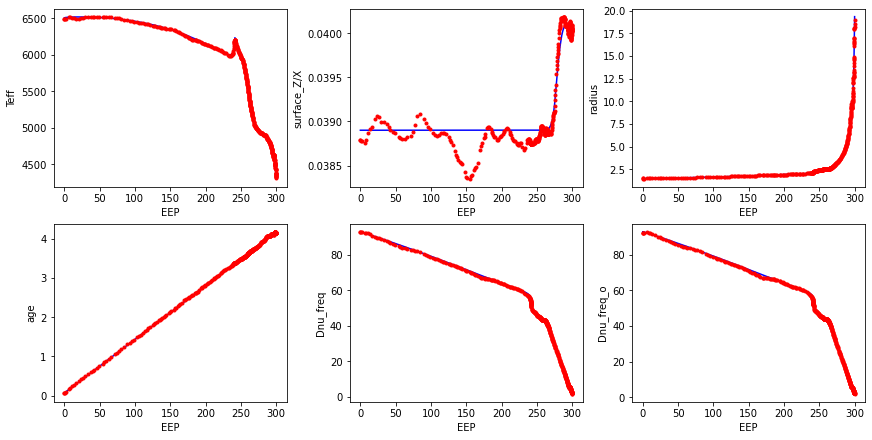

In [20]:
idx = df['index']==1
print(df[idx].iloc[0][['mass', 'amlt', 'Yinit', 'Zinit']])

with tf.device('/CPU:0'):
    predictions = 10.0**inv_scale_y(model.predict(scale_x(df.loc[idx, cols_inputs].to_numpy())) )
    actuals = 10.0**df.loc[idx,cols_outputs].to_numpy()

fig, axes = plt.subplots(figsize=[12,6], nrows=2, ncols=3, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

for ivar in range(len(cols_outputs)):
#     axes[ivar].plot(df.loc[idx,'eep'], actuals[:,ivar]-predictions[:,ivar], 'k.')
    axes[ivar].plot(df.loc[idx,'eep'], actuals[:,ivar], 'b-')
    axes[ivar].plot(df.loc[idx,'eep'], predictions[:,ivar], 'r.')
    
    axes[ivar].set_ylabel(cols_outputs[ivar][4:])
    axes[ivar].set_xlabel('EEP')

# Residuals

## Fractional differences distibution

In [23]:
idx = np.arange(0, len(idx_test), 100)
with tf.device('/CPU:0'):
    predictions = 10.0**inv_scale_y(model.predict( x[idx_test, :][idx,:] ))
    actuals = 10.0**inv_scale_y( y[idx_test,:][idx,:])


# xs = inv_scale_x(x[idx_test, :][idx,:])

idx = actuals[:,0]<6500
predictions, actuals = predictions[idx,:], actuals[idx,:]

618/618 [==============================] - 5s 8ms/step


Text(0, 0.5, 'Fractional residuals (%)')

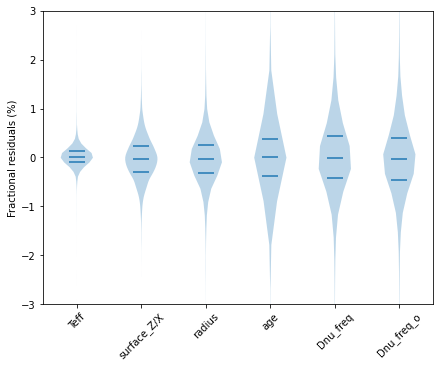

In [50]:
fig, axes = plt.subplots(figsize=[6, 5], nrows=1, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].violinplot((predictions/actuals-1)*100, quantiles=[[0.25, 0.75]]*6, showextrema=False, showmedians=True)

axes[0].set_ylim(-3, 3)
axes[0].set_xticks(range(1,7), [col[4:] for col in cols_outputs], rotation=45)
axes[0].set_ylabel('Fractional residuals (%)')

## Fractional differences distribution on the H-R diagram

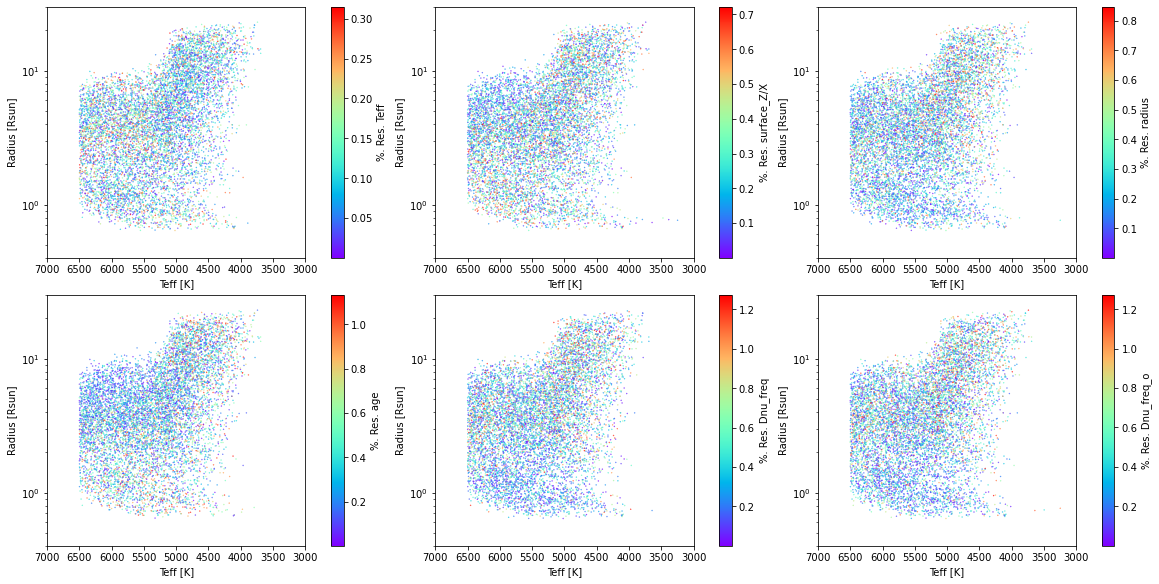

In [76]:
fig, axes = plt.subplots(figsize=[16,8], nrows=2, ncols=3, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)


for iax, ax in enumerate(axes):
    
    res = predictions[:,iax] / actuals[:,iax] - 1

    idx = (np.abs(res*100) < np.percentile(np.abs(res*100), 90) ) #& (actuals[:,0]<7000)

    c=ax.scatter(actuals[idx,0], actuals[idx,2], 
                c = np.abs(res*100)[idx], 
                marker='.', s=0.5,
                cmap='rainbow'
                )
    # predictions[:,i]-actuals[:,i], bins=100, 
    # label='std: {:.3f}'.format(np.std(predictions[:,i]-actuals[:,i]))
    plt.colorbar(c, ax=ax).set_label('%. Res. {}'.format(cols_outputs[iax][4:]))
    
    ax.set_yscale('log')

    ax.set_xlim(7000, 3000)
    ax.set_ylim(4e-1, 3e1)
    ax.set_xlabel('Teff [K]')
    ax.set_ylabel('Radius [Rsun]')

## Absolute differences distribution on the H-R diagram

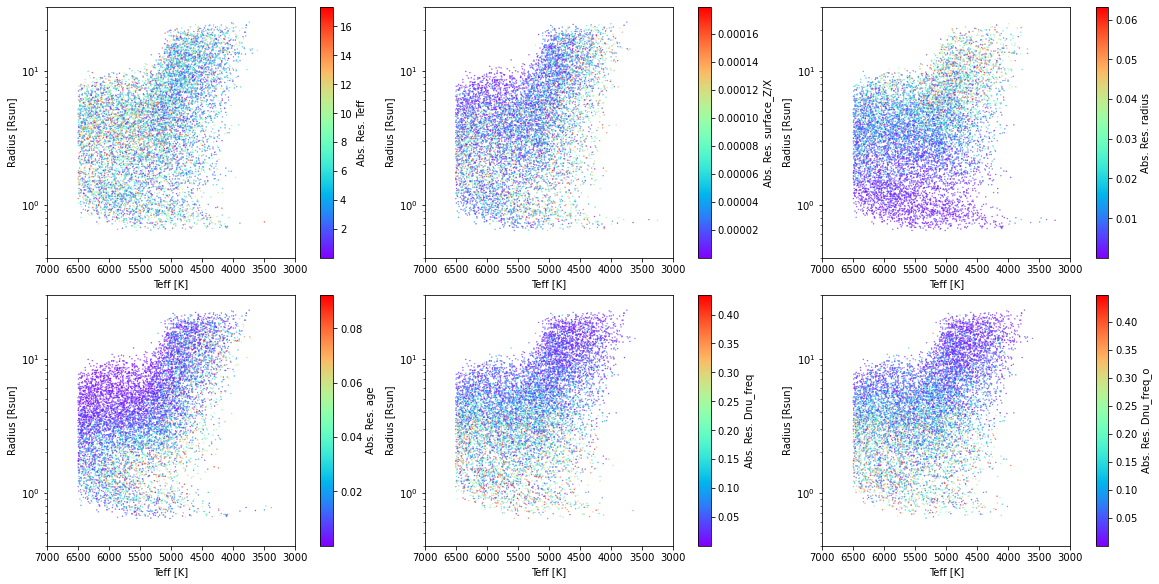

In [77]:
fig, axes = plt.subplots(figsize=[16,8], nrows=2, ncols=3, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)


for iax, ax in enumerate(axes):
    
    res = predictions[:,iax] - actuals[:,iax]

    idx = (np.abs(res) < np.percentile(np.abs(res), 90) ) #& (actuals[:,0]<7000)

    c=ax.scatter(actuals[idx,0], actuals[idx,2], 
                c = np.abs(res)[idx], 
                marker='.', s=0.5,
                cmap='rainbow'
                )
    # predictions[:,i]-actuals[:,i], bins=100, 
    # label='std: {:.3f}'.format(np.std(predictions[:,i]-actuals[:,i]))
    plt.colorbar(c, ax=ax).set_label('Abs. Res. {}'.format(cols_outputs[iax][4:]))
    
    ax.set_yscale('log')

    ax.set_xlim(7000, 3000)
    ax.set_ylim(4e-1, 3e1)
    ax.set_xlabel('Teff [K]')
    ax.set_ylabel('Radius [Rsun]')

# Predict

In [3]:
import h5py

# read in weights
with h5py.File('../models/fDnu/fDnu_ANN.h5', 'r') as f:
    groups = ['dense_{:.0f}'.format(i) for i in range(66, 75)]
    kernels = []
    biases = []
    for group in groups:
        kernels.append(f[f'model_weights/{group}/{group}/kernel:0'][:])
        biases.append(f[f'model_weights/{group}/{group}/bias:0'][:])

In [203]:
np.save('../models/fDnu/fDnu_ANN_weights', {'kernels':kernels, 'biases':biases})

In [217]:
d = np.load('../models/fDnu/fDnu_ANN_weights.npy', allow_pickle=True)[()]
kernels, biases = d['kernels'], d['biases']

In [218]:
kernels[0].shape

(5, 512)

In [219]:
biases[0].shape

(512,)

In [220]:
# A = np.array([0, 1, 2])

# B = np.array([[ 0,  1,  2,  3],
#               [ 4,  5,  6,  7],
#               [ 8,  9, 10, 11]])

xmin = np.array([[1.300214  , 0.22000916, 0.00156362, 0.70024   , 0.        ]])
xmax = np.array([[2.6999570e+00, 3.1999084e-01, 5.2185210e-02, 2.2999500e+00, 3.0000000e+02]])
ysig = np.array([[0.11590956, 0.43166455, 0.2986642 , 0.59469982, 0.42285968, 0.42092176]])
ymin = np.array([[ 3.47699917, -2.64096526, -0.21376869, -2.59942798,  0.22566342, 0.23851799]])

def scale_x(x):
    return (x - xmin) / (xmax - xmin)

def inv_scale_x(sx):
    return sx * (xmax - xmin) + xmin

def scale_y(y):
    return (y - ymin) / ysig

def inv_scale_y(sy):
    return sy * ysig + ymin

def leaky_relu(x, alpha=0.2):
    x[x<0] = alpha*x[x<0]
    return x

xs = np.array([[0.5, 0.5, 0.5, 0.2, 0.9],
               [0.5, 0.5, 0.5, 0.2, 0.9]], dtype='float32')
print('Input: amlt, Yinit, Zinit, mass, EEP')
print(inv_scale_x(xs))

r = np.copy(xs)

for ilayer in range(9):
    # multiply and sum
    r = np.einsum('ij, jk -> ik', r, kernels[ilayer]) + biases[ilayer]
    # apply activation function
    r = leaky_relu(r) 
    
ys = 10.0**inv_scale_y(r)
print('\nOutput: Teff, surface_Z/X, radius, age, Dnu_freq, Dnu_freq_o')

print('\n1, using numpy')
print(ys)

# tensorflow built-in API
with tf.device('/CPU:0'):
    ys_tf = 10.0**inv_scale_y(model.predict(xs))
    
print('\n2, using tensorflow')
print(ys_tf)


print('\nDifference')
print(ys-ys_tf)

Input: amlt, Yinit, Zinit, mass, EEP
[[2.00008550e+00 2.70000000e-01 2.68744150e-02 1.02018200e+00
  2.69999993e+02]
 [2.00008550e+00 2.70000000e-01 2.68744150e-02 1.02018200e+00
  2.69999993e+02]]

Output: Teff, surface_Z/X, radius, age, Dnu_freq, Dnu_freq_o

1, using numpy
[[5.39588335e+03 3.80181011e-02 1.49210413e+00 1.38337189e+01
  7.60124669e+01 7.61304181e+01]
 [5.39588335e+03 3.80181011e-02 1.49210413e+00 1.38337189e+01
  7.60124669e+01 7.61304181e+01]]
1/1 [==============================] - 0s 66ms/step

2, using tensorflow
[[5.39588232e+03 3.80181461e-02 1.49210364e+00 1.38336738e+01
  7.60125551e+01 7.61304885e+01]
 [5.39588232e+03 3.80181461e-02 1.49210364e+00 1.38336738e+01
  7.60125551e+01 7.61304885e+01]]

Difference
[[ 1.03005118e-03 -4.50466864e-08  4.89291882e-07  4.51639408e-05
  -8.82281442e-05 -7.03680585e-05]
 [ 1.03005118e-03 -4.50466864e-08  4.89291882e-07  4.51639408e-05
  -8.82281442e-05 -7.03680585e-05]]


# Sampler

In [115]:
# collect ANN weights
weights = np.load('../models/fDnu/fDnu_ANN_weights.npy', allow_pickle=True)[()]
kernels, biases = weights['kernels'], weights['biases']
kernels = [jnp.array(k) for k in kernels]
biases = [jnp.array(b) for b in biases]

# collect scaling parameters
xmin = jnp.array([[1.300214  , 0.22000916, 0.00156362, 0.70024   , 0.        ]])
xmax = jnp.array([[2.6999570e+00, 3.1999084e-01, 5.2185210e-02, 2.2999500e+00, 3.0000000e+02]])
ysig = jnp.array([[0.11590956, 0.43166455, 0.2986642 , 0.59469982, 0.42285968, 0.42092176]])
ymin = jnp.array([[ 3.47699917, -2.64096526, -0.21376869, -2.59942798,  0.22566342, 0.23851799]])

@jax.jit
def scale_x(x):
    return (x - xmin) / (xmax - xmin)

@jax.jit
def inv_scale_x(sx):
    return sx * (xmax - xmin) + xmin

@jax.jit
def scale_y(y):
    return (y - ymin) / ysig

@jax.jit
def inv_scale_y(sy):
    return sy * ysig + ymin

@jax.jit
def leaky_relu(x, alpha=0.2):
    x = jnp.where(x<0, 0.2*x, x)
    return x

@jax.jit
def stellar_stats_model(xs):
    '''
    Get observables (Teff, surface_Z/X, radius, age, Dnu_freq, Dnu_freq_o)
    given input parameters (amlt, Yinit, Zinit, mass, EEP).
    The input parameters must be in the range defined by xmin and xmax, 
    otherwise nan will be returned.
    
    Input:
    xs: array-like[num_sample, 5]
    
    Output:
    ys: array-like[num_sample, 6]
    
    '''
    
    xs = jnp.atleast_2d(xs)
    
    # min-max scale for input parameters
    r = scale_x(xs)

    for ilayer in range(9):
        # multiply and sum
        r = jnp.einsum('ij, jk -> ik', r, kernels[ilayer]) + biases[ilayer]
        # apply activation function
        r = leaky_relu(r) 
    
    # reverse std normalisation and log10 transform
    ys = 10.0**inv_scale_y(r)
    
    # filter those fall out of the input parameter range
    idx = jnp.transpose(jnp.array([jnp.sum((xmin < xs) & (xs < xmax), axis=1) != 5 ]*6))
    ys = jnp.where(idx, jnp.nan, ys)
    
    return ys

In [118]:
np.random.seed(0)

xs = inv_scale_x(jnp.array(np.random.rand(100000, 5)))
ys = stellar_stats_model(xs)

In [187]:
cols_inputs, cols_outputs

(['amlt', 'Yinit', 'Zinit', 'mass', 'eep'],
 ['log_Teff',
  'log_surface_Z/X',
  'log_radius',
  'log_age',
  'log_Dnu_freq',
  'log_Dnu_freq_o'])

## emcee

In [217]:
import emcee

cols_inputs = ['amlt', 'Yinit', 'Zinit', 'mass', 'eep']
cols_outputs = ['Teff', 'surface_Z/X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

Dnu_sun_model = 135.0959
density_sun_model = 1.00570

@jax.jit
def log_prob(xs, constraints):
    ys = stellar_stats_model(xs)
    
    # get physical properties of the star from the model predictions
    amlt, Yinit, Zinit, mass, eep = xs[:,0], xs[:,1], xs[:,2], xs[:,3], xs[:,4]
    
    # calculate the predicted observables for the star
    Teff, surface_Z_X, radius, age, Dnu_freq, Dnu_freq_o = ys[:,0], ys[:,1], ys[:,2], ys[:,3], ys[:,4], ys[:,5]
    
    # calculate some derived properties
    MH = jnp.log10(surface_Z_X) - jnp.log10(0.0181)
    lum = radius**2.0 * (Teff/5777)**4.0
    logg = jnp.log10(mass * radius**-2.0 * 274)
    density = mass * radius**-3.0 
    fDnu = (Dnu_freq/Dnu_sun_model) * (density/density_sun_model)**-0.5
    numax = mass * radius**-2.0 * (Teff/5777)**-0.5 * 3090.
    
    # calculate the log likelihood of the observables given the observational constraints
    log_like_Teff = -0. 
    log_like_MH = -0. 
    log_like_radius = -0. 
    log_like_age = -0. 
    log_like_Dnu = -0. 
    log_like_numax = -0. 
    log_like_lum = -0. 
    log_like_logg = -0. 
    log_like_mass = -0. 
    log_like_density = -0.
    
    if 'Teff' in constraints:
        log_like_Teff = jax.scipy.stats.norm.logpdf(Teff, constraints['Teff'], constraints['e_Teff'])
    if 'MH' in constraints:
        log_like_MH = jax.scipy.stats.norm.logpdf(MH, constraints['MH'], constraints['e_MH'])
    if 'radius' in constraints:
        log_like_radius = jax.scipy.stats.norm.logpdf(radius, constraints['radius'], constraints['e_radius'])
    if 'age' in constraints:
        log_like_age = jax.scipy.stats.norm.logpdf(age, constraints['age'], constraints['e_age'])
    if 'Dnu' in constraints:
        log_like_Dnu = jax.scipy.stats.norm.logpdf(Dnu_freq, constraints['Dnu'], constraints['e_Dnu'])
    if 'numax' in constraints:
        log_like_numax = jax.scipy.stats.norm.logpdf(numax, constraints['numax'], constraints['e_numax'])
    if 'lum' in constraints:
        log_like_lum =jax.scipy.stats.norm.logpdf(lum, constraints['lum'], constraints['e_lum'])
    if 'logg' in constraints:
        log_like_logg = jax.scipy.stats.norm.logpdf(logg, constraints['logg'], constraints['e_logg'])
    if 'mass' in constraints:
        log_like_mass = jax.scipy.stats.norm.logpdf(mass,constraints['mass'], constraints['e_mass'])
    if 'density' in constraints:
        log_like_density = jax.scipy.stats.norm.logpdf(density,constraints['density'], constraints['e_density'])
        
    # Calculate the total log likelihood
    total_log_like = log_like_Teff + log_like_MH + log_like_radius + log_like_age + \
                     log_like_Dnu + log_like_numax + log_like_lum + log_like_logg + \
                     log_like_mass + log_like_density
    
    total_log_like = jnp.where(jnp.isfinite(total_log_like), total_log_like, -jnp.inf)
    
    return total_log_like

# set up the observational constraints (observables) for a star
# let's pretend it is for the Sun
# supported constraints include Teff, MH, radius, age, Dnu, numax, lum, logg, mass, density

# the Sun
constraints = {
    'Teff': 5777,
    'e_Teff': 50,
    'MH': 0.0, 
    'e_MH': 0.06,
    'Dnu': 135.1,
    'e_Dnu': 1.0,
    'numax': 3090.,
    'e_numax': 100.,
    'lum': 1.0, 
    'e_lum': 0.1,
}

# KIC 10000547
constraints = {
    'Teff': 4969,
    'e_Teff': 50,
    'MH': -0.26, 
    'e_MH': 0.06,
    'Dnu': 13.212,
    'e_Dnu': 0.022,
    'numax': 160.75,
    'e_numax': 0.65,
    'lum': 12.68, 
    'e_lum': 0.51,
}


ndim, nwalkers = 5, 100
p0 = inv_scale_x(np.random.rand(nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[constraints], vectorize=True)
sampler.run_mcmc(p0, 5000, progress=True);

100%|██████████| 5000/5000 [01:17<00:00, 64.25it/s]


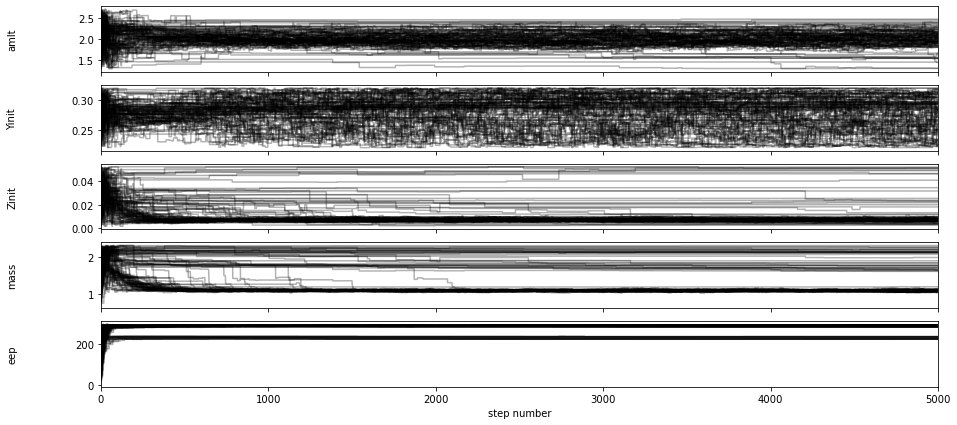

In [218]:
# examine the traces
fig, axes = plt.subplots(5, figsize=(15, 7), sharex=True)
samples = sampler.get_chain()
labels = cols_inputs
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

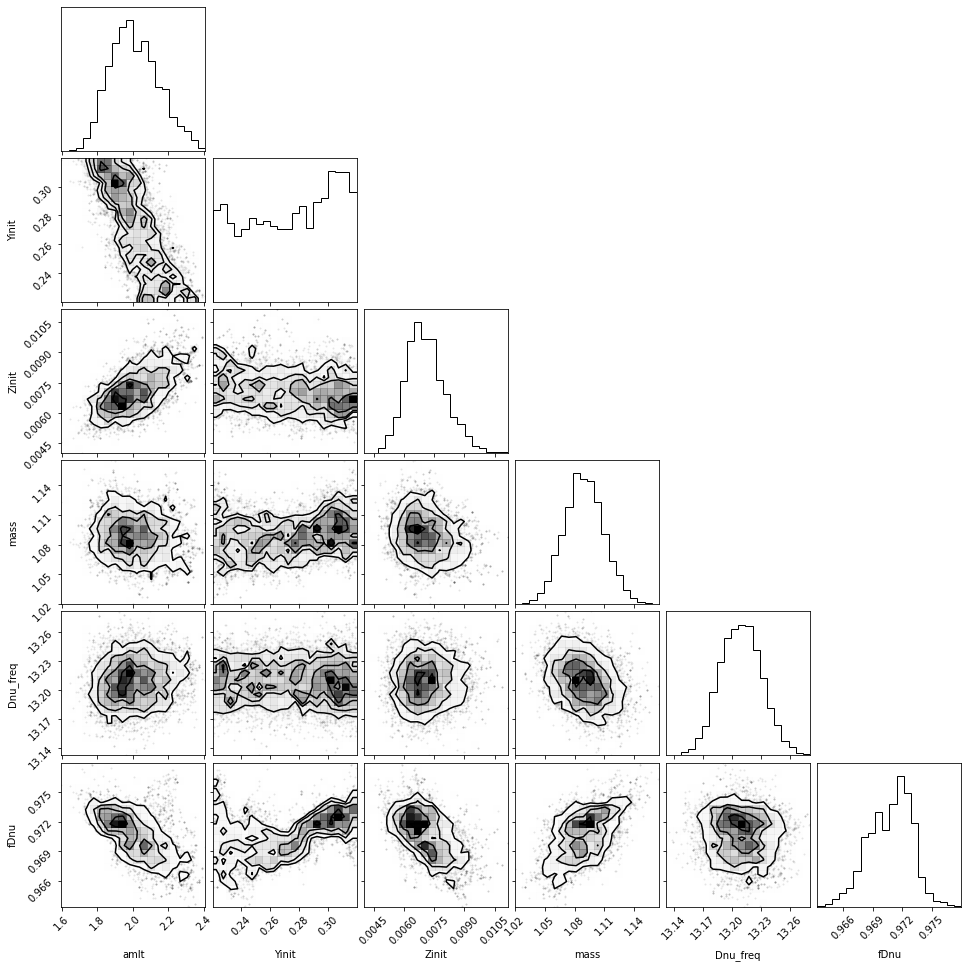

In [296]:
import corner

# get samples from emcee
xs = sampler.get_chain(discard=2500, flat=True)
ys = stellar_stats_model(xs)

# put everything into a pandas dataframe
samples = jnp.concatenate([xs, ys], axis=1).__array__()
samples = pd.DataFrame(samples, columns=cols_inputs+cols_outputs)

# add some new columns
samples['numax'] = samples['mass'] * samples['radius'] **-2.0 * (samples['Teff']/5777)**-0.5 * 3090.
samples['density'] = samples['mass'] * samples['radius']**-3.
samples['fDnu'] = (samples['Dnu_freq']/Dnu_sun_model) * (samples['density']/density_sun_model)**-0.5

# trim data points
samples = samples.sample(10000).query('age<12 & numax<165')

# make a corner plot
cols = ['amlt', 'Yinit', 'Zinit', 'mass', 'Dnu_freq', 'fDnu']
fig = corner.corner(samples[cols]);

In [297]:
# get quantities we care and their uncertainties
stats = samples.describe(percentiles=[0.16, 0.50, 0.84])

# this might be frowned upon, but is very simple
stats.loc['err',:] = (stats.loc['84%',:]-stats.loc['16%',:])/2. 

stats.loc['med',:] = stats.loc['50%',:]

stats = stats.loc[['med', 'err'],:]
stats

,amlt,Yinit,Zinit,mass,eep,Teff,surface_Z/X,radius,age,Dnu_freq,Dnu_freq_o,numax,density,fDnu
med,1.997649,0.277667,0.006993,1.089189,292.343597,4993.286133,0.009969,4.743739,5.733738,13.209179,13.436546,160.880905,0.010202,0.971030
err,0.139371,0.035605,0.000959,0.019692,1.414285,33.123291,0.001332,0.034641,1.562966,0.021815,0.029294,0.632641,0.000060,0.002222


## single star - scipy optimize

In [294]:
from scipy.optimize import basinhopping
import scipy.stats

cols_inputs = ['amlt', 'Yinit', 'Zinit', 'mass', 'eep']
cols_outputs = ['Teff', 'surface_Z/X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

Dnu_sun_model = 135.0959
density_sun_model = 1.00570

# @jax.jit
def minus_log_prob(xs, constraints):
    xs = np.atleast_2d(xs)
    ys = stellar_stats_model(xs)
    
    # get physical properties of the star from the model predictions
    amlt, Yinit, Zinit, mass, eep = xs[0,0], xs[0,1], xs[0,2], xs[0,3], xs[0,4]
    
    # calculate the predicted observables for the star
    Teff, surface_Z_X, radius, age, Dnu_freq, Dnu_freq_o = ys[0,0], ys[0,1], ys[0,2], ys[0,3], ys[0,4], ys[0,5]
    
    # calculate some derived properties
    MH = np.log10(surface_Z_X) - np.log10(0.0181)
    lum = radius**2.0 * (Teff/5777)**4.0
    logg = np.log10(mass * radius**-2.0 * 274)
    density = mass * radius**-3.0 
    fDnu = (Dnu_freq/Dnu_sun_model) * (density/density_sun_model)**-0.5
    numax = mass * radius**-2.0 * (Teff/5777)**-0.5 * 3090.
    
    # calculate the log likelihood of the observables given the observational constraints
    log_like_Teff = -0. 
    log_like_MH = -0. 
    log_like_radius = -0. 
    log_like_age = -0. 
    log_like_Dnu = -0. 
    log_like_numax = -0. 
    log_like_lum = -0. 
    log_like_logg = -0. 
    log_like_mass = -0. 
    log_like_density = -0.
    
    if 'Teff' in constraints:
        log_like_Teff = scipy.stats.norm.logpdf(Teff, constraints['Teff'], constraints['e_Teff'])
    if 'MH' in constraints:
        log_like_MH = scipy.stats.norm.logpdf(MH, constraints['MH'], constraints['e_MH'])
    if 'radius' in constraints:
        log_like_radius = scipy.stats.norm.logpdf(radius, constraints['radius'], constraints['e_radius'])
    if 'age' in constraints:
        log_like_age = scipy.stats.norm.logpdf(age, constraints['age'], constraints['e_age'])
    if 'Dnu' in constraints:
        log_like_Dnu = scipy.stats.norm.logpdf(Dnu_freq, constraints['Dnu'], constraints['e_Dnu'])
    if 'numax' in constraints:
        log_like_numax = scipy.stats.norm.logpdf(numax, constraints['numax'], constraints['e_numax'])
    if 'lum' in constraints:
        log_like_lum =scipy.stats.norm.logpdf(lum, constraints['lum'], constraints['e_lum'])
    if 'logg' in constraints:
        log_like_logg = scipy.stats.norm.logpdf(logg, constraints['logg'], constraints['e_logg'])
    if 'mass' in constraints:
        log_like_mass = scipy.stats.norm.logpdf(mass,constraints['mass'], constraints['e_mass'])
    if 'density' in constraints:
        log_like_density = scipy.stats.norm.logpdf(density,constraints['density'], constraints['e_density'])
        
    # Calculate the total log likelihood
    total_log_like = log_like_Teff + log_like_MH + log_like_radius + log_like_age + \
                     log_like_Dnu + log_like_numax + log_like_lum + log_like_logg + \
                     log_like_mass + log_like_density
    
    
    return -float(total_log_like)

# set up the observational constraints (observables) for a star
# let's pretend it is for the Sun
# supported constraints include Teff, MH, radius, age, Dnu, numax, lum, logg, mass, density

# the Sun
constraints = {
    'Teff': 5777,
    'e_Teff': 50,
    'MH': 0.0, 
    'e_MH': 0.06,
    'Dnu': 135.1,
    'e_Dnu': 1.0,
    'numax': 3090.,
    'e_numax': 100.,
    'lum': 1.0, 
    'e_lum': 0.1,
}

# # KIC 10000547
# constraints = {
#     'Teff': 4969,
#     'e_Teff': 50,
#     'MH': -0.26, 
#     'e_MH': 0.06,
#     'Dnu': 13.212,
#     'e_Dnu': 0.022,
#     'numax': 160.75,
#     'e_numax': 0.65,
#     'lum': 12.68, 
#     'e_lum': 0.51,
# }

# def fit(params, optimizer):
#     opt_state = optimizer.init(params)

#     @jax.jit
#     def step(params, opt_state):
#         loss_value, grads = jax.value_and_grad(minus_log_prob, argnums=0)(params, constraints)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         return params, opt_state, loss_value

#     for i  in range(100):
#         params, opt_state, loss_value = step(params, opt_state)
#         if i % 10 == 0:
#             print(f'step {i}, loss: {loss_value}')

#     return params

paramsInit = inv_scale_x(np.array([0.5]*5))
res = basinhopping(minus_log_prob, paramsInit, minimizer_kwargs={'args':constraints, 'bounds':np.array([*xmin, *xmax]).T})
# optimizer = optax.adam(learning_rate=1e-2)
# params = fit(paramsInit, optimizer)
res.x

array([2.00008535e+00, 2.70000011e-01, 2.68744156e-02, 1.50009489e+00,
       1.50000000e+02])

In [281]:
paramsInit

DeviceArray([[2.0000854e+00, 2.7000001e-01, 2.6874416e-02, 1.5000949e+00,
              1.5000000e+02]], dtype=float32)